In [6]:
# Data Cleaning and Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
import warnings
warnings.filterwarnings('ignore')


In [7]:
# Load the dataset 
#df = pd.read_csv('../../../raw/student_depression_dataset.csv')
import os

# Get the project root based on the notebook's location
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../'))   # go up to project root

# Create a path to your dataset
csv_path = os.path.join(project_root, 'Data', 'raw', 'student_depression_dataset.csv')

# Load it

df = pd.read_csv(csv_path)

In [8]:
# Step 2: Convert 'Financial Stress' to numeric early to avoid TypeError
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors='coerce')

# Handle replacements for missing/invalid values
df['Sleep Duration'] = df['Sleep Duration'].replace("Others", np.nan)
df['Financial Stress'] = df['Financial Stress'].replace("?", np.nan)
df['Dietary Habits'] = df['Dietary Habits'].replace("Others", np.nan)


In [ ]:
# Step 3: Clean Corrupted/Inconsistent Data 
for col in ['Profession', 'Sleep Duration', 'Degree']:
    df[col] = df[col].str.replace("'", "", regex=False)

In [ ]:
# Step 4: Handle Missing Values

# Fill missing values for categorical columns with mode
df['Sleep Duration'].fillna(df['Sleep Duration'].mode()[0] if not df['Sleep Duration'].mode().empty else '5-6 hours', inplace=True)
df['Dietary Habits'].fillna(df['Dietary Habits'].mode()[0] if not df['Dietary Habits'].mode().empty else 'Moderate', inplace=True)

# Fill missing values for numerical columns with median
df['Financial Stress'].fillna(df['Financial Stress'].median(), inplace=True)
df['Academic Pressure'].fillna(df['Academic Pressure'].median(), inplace=True)
df['CGPA'].fillna(df['CGPA'].median(), inplace=True)
df['Study Satisfaction'].fillna(df['Study Satisfaction'].median(), inplace=True)
df['Work/Study Hours'].fillna(df['Work/Study Hours'].median(), inplace=True)

In [11]:
# Step 5: Clean City column
city_map = {
    'Less Delhi': 'Delhi', 'Less than 5 Kalyan': 'Kalyan', 'Khaziabad': 'Ghaziabad',
    'Nalyan': 'Nalanda', '3.0': 'Unknown', 'M.Com': 'Unknown', 'M.Tech': 'Unknown',
    'ME': 'Unknown', 'Saanvi': 'Other', 'Harsha': 'Other', 'Bhavna': 'Other',
    'Gaurav': 'Other', 'Harsh': 'Other', 'Kibara': 'Other', 'Nalini': 'Other',
    'Mihir': 'Other', 'Mira': 'Other', 'Reyansh': 'Other', 'Rashi': 'Other',
    'Nandini': 'Other', 'Vaanya': 'Other', 'City': 'Other'
}
df['City'] = df['City'].replace(city_map)
city_counts = df['City'].value_counts()
low_freq_cities = city_counts[city_counts < 28].index
df.loc[df['City'].isin(low_freq_cities), 'City'] = 'Other'

# Handle low-frequency professions and degrees
profession_counts = df['Profession'].value_counts()
low_freq_profs = profession_counts[profession_counts < 8].index
df.loc[df['Profession'].isin(low_freq_profs), 'Profession'] = 'Other'
df.loc[df['Degree'] == 'Others', 'Degree'] = 'Unknown'


In [12]:
# Step 6: Feature Engineering (must be before encoding categorical variables)
# Create Degree_Level
degree_bins = {
    'Class 12': 'School-Level',
    'B.Com': 'Undergraduate', 'B.Arch': 'Undergraduate', 'B.Tech': 'Undergraduate',
    'B.Ed': 'Undergraduate', 'BBA': 'Undergraduate', 'BCA': 'Undergraduate',
    'BHM': 'Undergraduate', 'BSc': 'Undergraduate', 'B.Pharm': 'Undergraduate',
    'BA': 'Undergraduate', 'LLB': 'Undergraduate', 'BE': 'Undergraduate',
    'MBA': 'Postgraduate', 'M.Com': 'Postgraduate', 'M.Tech': 'Postgraduate',
    'MCA': 'Postgraduate', 'M.Ed': 'Postgraduate', 'MA': 'Postgraduate',
    'M.Pharm': 'Postgraduate', 'MSc': 'Postgraduate', 'LLM': 'Postgraduate',
    'MD': 'Postgraduate', 'ME': 'Postgraduate', 'MHM': 'Postgraduate',
    'PhD': 'Doctoral/Other', 'Others': 'Doctoral/Other', 'MBBS': 'Doctoral/Other'
}
df['Degree_Level'] = df['Degree'].map(degree_bins).fillna('Doctoral/Other')

# Group Profession
df['Profession_Grouped'] = df['Profession'].apply(lambda x: 'Student' if 'student' in str(x).lower() else 'Other')


In [13]:
# Step 7: Handle Sparse Columns
df['is_student'] = (df['Profession'] == 'Student').astype(int)
df.loc[df['is_student'] == 1, ['Work Pressure', 'Job Satisfaction']] = np.nan
df['Work Pressure'].fillna(df['Work Pressure'].median(), inplace=True)
df['Job Satisfaction'].fillna(df['Job Satisfaction'].median(), inplace=True)

In [14]:
# Step 8: Handle Outliers and Invalid Values
df['Age'] = df['Age'].clip(upper=35)
df['CGPA'] = df['CGPA'].clip(lower=0, upper=10)
median_hours = df[df['Work/Study Hours'] > 0]['Work/Study Hours'].median()
if pd.notna(median_hours):
    df.loc[df['Work/Study Hours'] == 0, 'Work/Study Hours'] = median_hours

In [15]:
# Step 9: Ordinal Encoding for Sleep Duration
# Ensure all values are clean before mapping
sleep_order = {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}
df['Sleep Duration'] = df['Sleep Duration'].map(sleep_order)
# If any values remain unmapped (NaN), fill with the mode of mapped values or a default (e.g., 2 for '5-6 hours')
df['Sleep Duration'].fillna(df['Sleep Duration'].mode()[0] if not df['Sleep Duration'].mode().empty else 2, inplace=True)



In [16]:
# Step 10: Encode Categorical Variables (after feature engineering)
le = LabelEncoder()
for col in ['Gender', 'City', 'Profession', 'Degree', 'Dietary Habits', 'Degree_Level', 
            'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']:
    df[col] = le.fit_transform(df[col].astype(str))



In [17]:
# Step 11: Binarization
lb = LabelBinarizer()
df['Profession_Binary'] = lb.fit_transform(df['Profession_Grouped'])

# Adjust binary mappings for numeric fields
df['Work_Pressure_Binary'] = df['Work Pressure'].apply(lambda x: 1 if pd.notna(x) and x > 3 else 0)
df['Job_Satisfaction_Binary'] = df['Job Satisfaction'].apply(lambda x: 1 if pd.notna(x) and x > 3 else 0)



In [18]:
# Step 12: Scale Numerical Features
scaler = StandardScaler()
numerical_cols = ['Age', 'CGPA', 'Work/Study Hours', 'Financial Stress', 'Academic Pressure', 'Study Satisfaction']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



In [19]:
# Step 13: Save Cleaned Data
df.to_csv('cleaned_student_depression.csv', index=False)



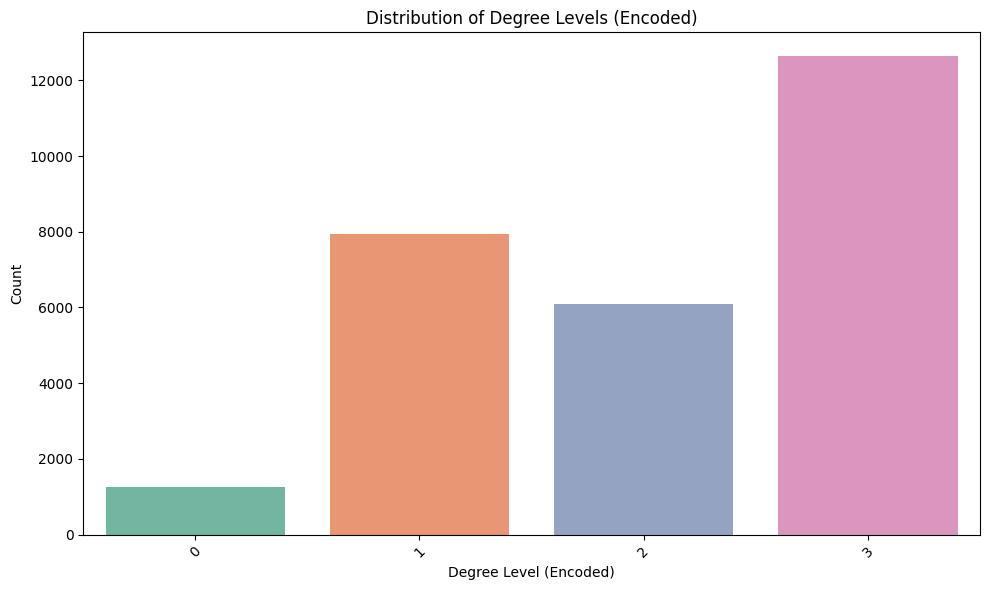

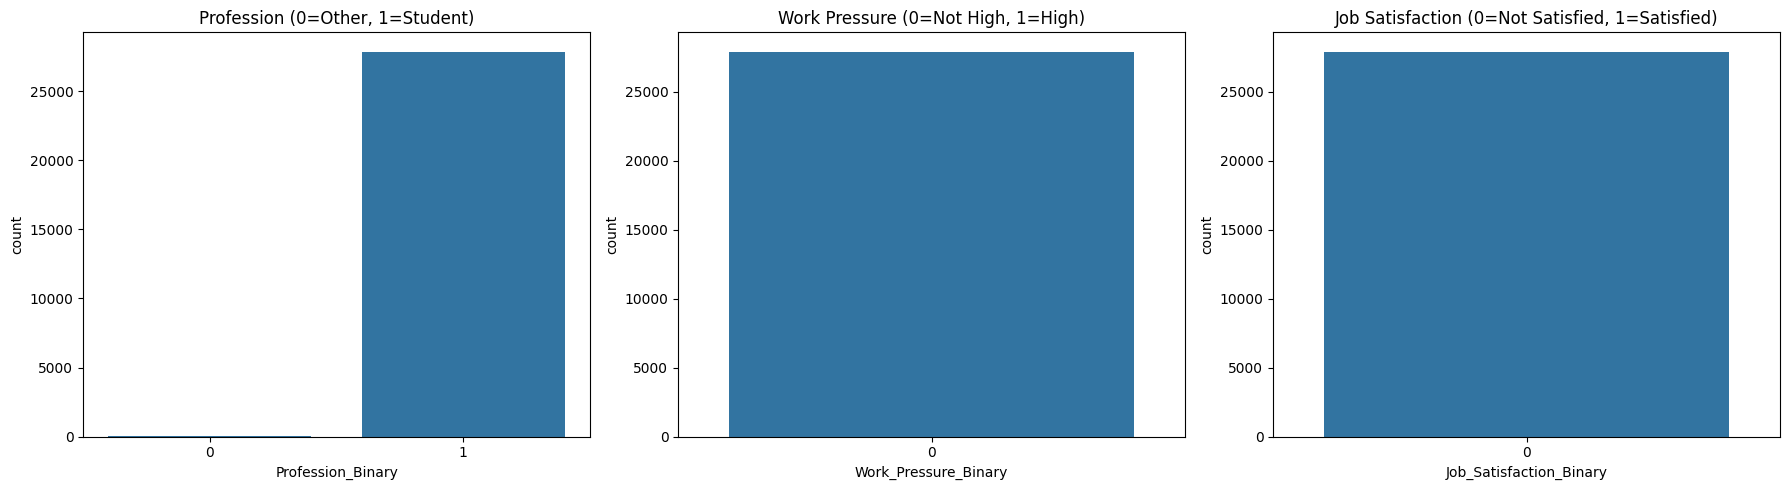

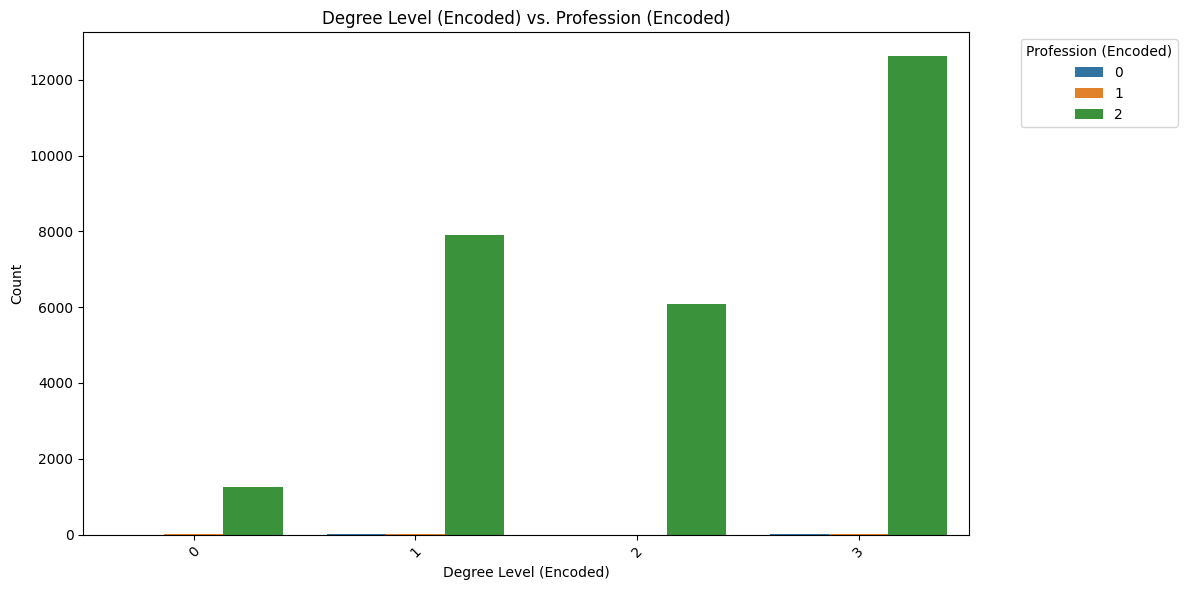


Missing Values After Cleaning:
id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Degree_Level                             0
Profession_Grouped                       0
is_student                               0
Profession_Binary                        0
Work_Pressure_Binary  

In [20]:
# Step 14: Visualizations
# Distribution of Degree Levels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Degree_Level', palette='Set2')
plt.title('Distribution of Degree Levels (Encoded)')
plt.xlabel('Degree Level (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Subplots for Profession, Work Pressure, and Job Satisfaction
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Profession
sns.countplot(x='Profession_Binary', data=df, ax=axes[0])
axes[0].set_title('Profession (0=Other, 1=Student)')

# Work Pressure
sns.countplot(x='Work_Pressure_Binary', data=df, ax=axes[1])
axes[1].set_title('Work Pressure (0=Not High, 1=High)')

# Job Satisfaction
sns.countplot(x='Job_Satisfaction_Binary', data=df, ax=axes[2])
axes[2].set_title('Job Satisfaction (0=Not Satisfied, 1=Satisfied)')

plt.tight_layout()
plt.show()

# Degree Level vs. Profession (filter top professions for clarity)
top_professions = df['Profession'].value_counts().nlargest(10).index
filtered_df = df[df['Profession'].isin(top_professions)]
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='Degree_Level', hue='Profession', palette='tab10')
plt.title('Degree Level (Encoded) vs. Profession (Encoded)')
plt.xlabel('Degree Level (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Profession (Encoded)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Verify final state
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())
print("\nDataFrame Info:")
print(df.info())